In [1]:
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

pd.set_option('display.max_columns', None)

In [2]:
from database import YelpDataBase
ydb = YelpDataBase()

What categories have the largest number of reviews and businesses associated with them. Note here that each review is about a business and each business can have multiple categories, thus reviews can cover multiple categories.

In [3]:
statement = """SELECT category.name, COUNT(reviews.id) AS num_reviews, COUNT(DISTINCT business.id) AS num_business
                FROM reviews JOIN business ON reviews.business_id  == business.id
                JOIN category_business ON business.id == category_business.business_id
                JOIN category ON category_business.category_id == category.id
                GROUP BY category.name ORDER BY num_reviews DESC LIMIT 20"""
ydb.execute_sql_statement(statement, as_frame=True)

,name,num_reviews,num_business
0,Restaurants,4724471,52268
1,Food,1813593,27781
2,Nightlife,1539757,12281
3,Bars,1455553,11065
4,American (Traditional),1011646,8139
5,American (New),984540,6097
6,Breakfast & Brunch,867430,6239
7,Sandwiches,691864,8366
8,Seafood,620247,3539
9,Event Planning & Services,609553,9895


Is there a correlation between the number of reviews a user posts and the number of fans they have

In [4]:
statement = """SELECT review_count, fans 
                FROM users
                WHERE review_count NOT NULL AND fans NOT NULL"""
review_fans = ydb.execute_sql_statement(statement, as_frame=True)

In [5]:
print(review_fans.shape)
review_fans.sample(10)

(1987897, 2)


,review_count,fans
1084375,26,0
1631713,24,0
1331586,15,1
893919,2,0
1645872,1,0
460783,186,2
1509313,4,0
821018,256,7
1255263,5,0
1214901,4,0


In [6]:
# we want to look at the correlation between review_count and fans both visually and with the pearson r value.
# to visualize this relationship we will take a random sample of 10000 users as we dont want to plot all 1.9 million
samp_review_fans = review_fans.sample(10000)

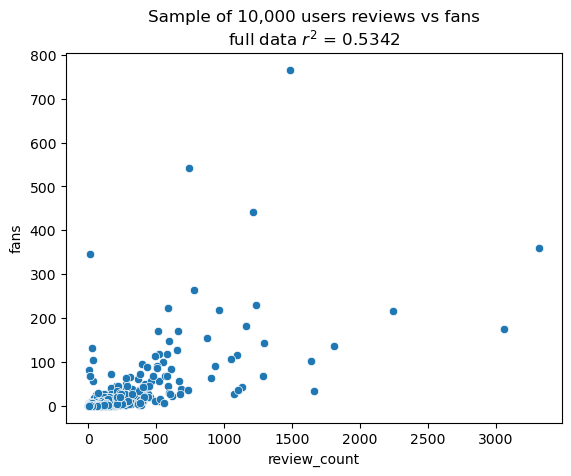

In [7]:
pr = pearsonr(review_fans['review_count'], review_fans['fans'])
ax = sns.scatterplot(data=samp_review_fans, x='review_count', y='fans')
ax.set_title(f'Sample of 10,000 users reviews vs fans\nfull data $r^2$ = {pr[0]:.4f}')
plt.show()

users with most elite years

In [8]:
statement = """SELECT users.name, COUNT(elite.year) AS years_elite
                FROM users JOIN elite ON users.id = elite.user_id
                GROUP BY users.id ORDER BY years_elite DESC LIMIT 5"""
ydb.execute_sql_statement(statement, as_frame=True)

,name,years_elite
0,Sarah,16
1,Joc,16
2,Wendy,16
3,Jeff,16
4,Megan,16


states with the highest average number of stars

In [9]:
statement = """SELECT business.state, business.stars, COUNT(DISTINCT reviews.id) as num_reviews
                FROM business JOIN reviews on business.id = reviews.business_id
                GROUP BY business.state
                ORDER BY business.stars DESC LIMIT 10"""
ydb.execute_sql_statement(statement, as_frame=True)

,state,stars,num_reviews
0,MT,5.0,6
1,VT,4.5,10
2,UT,4.5,19
3,SD,4.5,42
4,IL,4.5,51832
5,DE,4.5,70302
6,CA,4.5,348856
7,XMS,4.0,5
8,TN,4.0,614388
9,NJ,4.0,260897


network analysis

In [10]:
statement = """SELECT users.id, users.name, users.review_count, users.average_stars, friends.user2_id AS friends
                FROM users JOIN friends on users.id = friends.user1_id"""
network_data = ydb.execute_sql_statement(statement, as_frame=True)

In [11]:
print('Network Data Shape: ', network_data.shape)
network_data.sample(10)

Network Data Shape:  (14611748, 5)


,id,name,review_count,average_stars,friends
13656815,1662349,Eric,1,5.00,459174
5344286,286637,Janice,1,1.00,1815555
12429182,1426368,Francesca,84,4.18,1602194
221549,1550,Brian,245,4.10,625175
5830612,409350,Van,1896,3.90,10669
2420796,65483,Julia,12,4.00,1208672
2219695,57397,Rhasheda,5,2.80,634499
14287766,1826312,Amanda,3,4.00,202825
13029085,1603017,Andrew,72,3.01,799109
11386563,1228648,Felix,3,5.00,227444


In [12]:
def build_node_list(df):
    node_list = []
    for node in df[['id', 'name', 'review_count', 'average_stars']].drop_duplicates().itertuples(index=False):
        user_node_id = node.id
        node_attributes = {'name': node.name, 'review_count': node.review_count, 'average_stars': node.average_stars}
        node_ = (user_node_id, node_attributes)
        node_list.append(node_)
    return node_list

def build_edge_list(df):
    edge_list = [(node.id, node.friends) for node in df[['id', 'friends']].itertuples()]
    return edge_list

In [13]:
def build_save_graph(df, path:str):
    graph = nx.Graph()
    graph.add_nodes_from(build_node_list(df))
    graph.add_edges_from(build_edge_list(df))
    nx.write_graphml_lxml(graph, path)
    return graph

def load_graph(path:str):
    graph = nx.read_graphml(path)
    return graph

In [14]:
graph_path = 'data/user_friend_graph.graphml'

user_graph = build_save_graph(network_data, graph_path)
# user_graph = load_graph(graph_path)

In [15]:
deg_hist = nx.degree_histogram(user_graph)

Text(0.5, 0, 'degree')

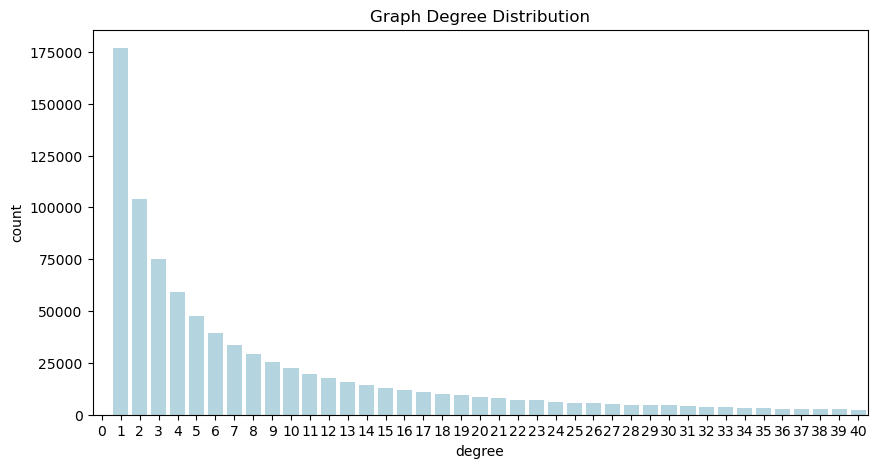

In [16]:
show_max = 40
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=list(range(len(deg_hist[:show_max + 1]))), y=deg_hist[:show_max + 1], color='lightblue', ax=ax)
ax.set_title('Graph Degree Distribution')
ax.set_ylabel('count')
ax.set_xlabel('degree')

In [17]:
def show_component_stats_get_largest(graph, show_largest:int=10):
    sorted_components = sorted(nx.connected_components(graph), key=len, reverse=True)
    components_sizes = [len(comp) for comp in sorted_components]

    print('Number of connected components     : ', len(sorted_components))
    print(f'Top {show_largest} largest connected components: ', ', '.join([str(num) for num in components_sizes[:show_largest]]))

    sub_graph = nx.subgraph(user_graph, sorted_components[0])
    return sub_graph

In [18]:
largest_connected_component = show_component_stats_get_largest(user_graph)

Number of connected components     :  6711
Top 10 largest connected components:  892152, 7, 6, 6, 5, 5, 5, 5, 5, 5


Degree Centrality: "The degree centrality for a node v is the fraction of nodes it is connected to." https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality<br>

In [19]:
dcnode, dcentrality = max(nx.degree_centrality(user_graph).items(), key=lambda x: x[1])
name, review_count, stars = user_graph.nodes[dcnode]['name'], user_graph.nodes[dcnode]['review_count'], user_graph.nodes[dcnode]['average_stars']
print(f"Node with largest degree centrality: {dcnode}, user name: {name}, review count: {review_count}, average rating: {stars}, degree centrality: {dcentrality}")

Node with largest degree centrality: 2363, user name: Steven, review count: 1371, average rating: 3.62, degree centrality: 0.007579084903848913
